# 🎓🕸️ Grafy a sociální sítě

<sup>BI-VIZ @ FIT CTU </sup>

V tomto Jupyter Notebooku 📖 si ukážeme základní práci s grafy pomocí knihovny [NetworkX](https://networkx.org/documentation/stable/index.html) - jejich sestrojení, základní analýzu a vizualizaci.👀

Pro zajímavost citace k [%matplotlib inline](https://ipython.readthedocs.io/en/stable/interactive/plotting.html): _With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document._

In [1]:
%matplotlib inline

In [2]:
import collections
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import re
import math
import json

from pprint import pprint
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import networkx as nx

# 🌐 NetworkX
[NetworkX](https://networkx.org/documentation/stable/index.html) je jedna z nejpopulárnějších knihoven pro práci s grafy a grafovými algoritmy. Díky ní můžeme grafy analyzovat, vizualizovat (v rozumné míře), transformovat, nebo sledovat jejich vlastnosti.

NetworkX primárně není balíček pro kreslení grafů, ale obsahuje základní vykreslení pomocí Matplotlib a rozhraní pro použití open source balíčku [Graphviz](https://graphviz.org). Obojí je součástí modulu `networkx.drawing`. Různé ukázky grafů a jejich nastavení (popisky apod.) najdete v [NetworkX Gallery](https://networkx.org/documentation/latest/auto_examples/index.html).

🙈🤷‍♀️ Základní funkcionalita pro vykreslení grafů má být v budoucnu z knihovny údajně odstraněna. V dokumentaci je doporučeno pro vizualizace využít k tomu určené nástroje jako např. [Cytoscape](https://cytoscape.org), [Gephi](https://gephi.org) nebo [Graphviz](https://graphviz.org).

## ☝️ Tvorba grafu

Základním stavebním kamenem je instance Grafu. V NetworkX se nachází třídy [`nx.Graph`](https://networkx.org/documentation/stable/reference/classes/graph.html) pro neorientovaný a [`nx.DiGraph`](https://networkx.org/documentation/stable/reference/classes/digraph.html) pro orientovaný graf. </br>
V knihovně dále existuje implementace těchto tříd, která dovoluje vícenásobný počet hran mezi vrcholy [`nx.MultiGraph`](https://networkx.org/documentation/stable/reference/classes/multigraph.html) a [`nx.MultiDiGraph`](https://networkx.org/documentation/stable/reference/classes/multidigraph.html).

In [3]:
G = nx.Graph()
print(G) # to get graph properties

Graph with 0 nodes and 0 edges


Což je samo o sobě samozřejmě k ničemu...

## ☝️ Populace grafu

Pojďme si vytvořit graf států střední Evropy 🌍:

<img width=500 height=500 src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/16/Central_Europe_%28Brockhaus%29.svg/1280px-Central_Europe_%28Brockhaus%29.svg.png" alt="central europa"/>

Zdroj: https://en.wikipedia.org/wiki/Central_Europe.

🏔 Pro **přidání vrcholů** do grafu můžeme použít metodu [`add_node(label, **kwargs)`](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.add_node.html).

In [4]:
G.add_node("Czechia", type="country")

kde pomocí prvního argumentu specifikujeme identifikátor vrcholu (`číslo`, `řetězec`, `tuple`, apod.) a pomocí keyword argumentů (kwargs) specifikujeme **atributy vrcholu** ve formátu `klíč=hodnota`.

Počty atributů a jejich hodnoty mohou být pokaždé různé.

In [5]:
G.add_node("Prague", type="city", population=1309000)

Jednotlivé uzly si můžeme vypsat následovně:

In [6]:
G.nodes()

NodeView(('Czechia', 'Prague'))

Obdobně můžeme přidat několik vrcholů najednou pomocí [`add_nodes_from(iterable, **kwargs)`](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.add_nodes_from.html)

In [7]:
countries = ["Slovakia", "Hungary", "Poland", "Germany", "Austria"]
G.add_nodes_from(countries, type="country")
G.nodes()

NodeView(('Czechia', 'Prague', 'Slovakia', 'Hungary', 'Poland', 'Germany', 'Austria'))

In [8]:
cities = ["Bratislava", "Budapest", "Warsaw", "Berlin", "Vienna"]
G.add_nodes_from(cities, type="city")
G.nodes()

NodeView(('Czechia', 'Prague', 'Slovakia', 'Hungary', 'Poland', 'Germany', 'Austria', 'Bratislava', 'Budapest', 'Warsaw', 'Berlin', 'Vienna'))

S **přidáváním hran** je to už trochu složitější. Do metody [`add_edge`](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.add_edge.html) vkládáme dvojici vrcholů `u` a `v`, mezi kterými následně vznikne (orientovaná) hrana. Stejným způsobem jako výše lze přidat také atributy hrany (včetně vážení hran nějakou číselnou hodnotou pomocí atributu `weight`). Nevýhodou je pracné vypisování těchto dvojic, proto doporučujeme proces zautomatizovat (např. pomocí [`add_edges_from`](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.add_edges_from.html)). 

Pojďme přidat hrany mezi státy a hlavní města:

In [9]:
countries += ["Czechia"]
for i, x in enumerate(countries):
    print(i, x)

0 Slovakia
1 Hungary
2 Poland
3 Germany
4 Austria
5 Czechia


In [10]:
cities += ["Prague"]
for i, x in enumerate(cities):
    print(i, x)

0 Bratislava
1 Budapest
2 Warsaw
3 Berlin
4 Vienna
5 Prague


In [11]:
G.add_edges_from(zip(countries, cities), type="capital")

# namísto
# G.add_edge("Prague", "Czechia", type="capital")
# G.add_edge("Bratislava", "Slovakia", type="capital")
# G.add_edge("Budapest", "Hungary", type="capital")
# G.add_edge("Warsaw", "Poland", type="capital")
# G.add_edge("Berlin", "Germany", type="capital")
# G.add_edge("Austria", "Vienna", type="capital")

☝️ Následujícím způsobem ještě propojíme sousední státy:

In [12]:
neighbouring_countries_indexes = [
    [0, 1],
    [0, 2],
    [0, 5],
    [1, 4],
    [2, 3],
    [2, 5],
    [3, 4],
    [3, 5],
    [4, 5],
]

In [13]:
for (u_idx, v_idx) in neighbouring_countries_indexes:
    G.add_edge(countries[u_idx], countries[v_idx], relation="neighbour")

In [14]:
# zobrazení všech hran
G.edges

EdgeView([('Czechia', 'Prague'), ('Czechia', 'Slovakia'), ('Czechia', 'Poland'), ('Czechia', 'Germany'), ('Czechia', 'Austria'), ('Slovakia', 'Bratislava'), ('Slovakia', 'Hungary'), ('Slovakia', 'Poland'), ('Hungary', 'Budapest'), ('Hungary', 'Austria'), ('Poland', 'Warsaw'), ('Poland', 'Germany'), ('Germany', 'Berlin'), ('Germany', 'Austria'), ('Austria', 'Vienna')])

## ☝️ Vykreslení grafu

A teď si celý graf vykreslíme pomocí funkce [`nx.draw_network(Graph)`](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html), případně ořezaná verze [`nx.draw(Graph)`](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#draw).

Pokud chcete graf vykreslit do specifické Axes, zadává se jako parametr 'ax' funkce 'draw_networkx()'. Pro více vizte dokumentaci.

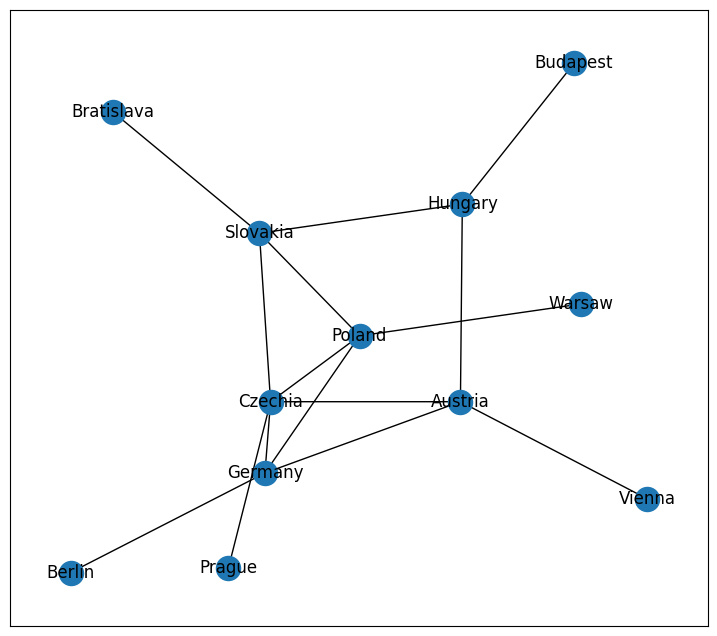

In [15]:
# create Figure and Axes object an simply pass it to nx.draw

fig, ax = plt.subplots(figsize=(9, 8))
nx.draw_networkx(G, with_labels=True)

👀 Takový graf je sice pěkný, ale je zde hodně prostoru pro zlepšení. Například pozice vrcholů neodpovídají jejich reálným pozicím na mapě.🌍

☝️ Jak zafixovat rozložení vygenerovaného grafu? Např. u [random_layout()](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.random_layout.html#networkx.drawing.layout.random_layout) existuje parametr 'seed', pomocí kterého můžete zafixovat generování vždy stejného uspořádání. Nicméně tento parametr není k dispozici vždy a např. u prostého 'nx.draw_networkx()' k dispozici není. Pokud narazíte na nějaké univerální řešení, dejte prosím vědět. 🙏


Rozložení vrcholů můžete ovládat i manuálně. Jako první zkusíme nastavit pozice jednotlivých vrcholů podle GPS souřadnic (u států se jedná o geografický střed).

In [16]:
country_pos = {}

In [17]:
# délka, šířka
country_pos["Czechia"] = np.array([15.472962, 49.817492])
country_pos["Germany"] = np.array([10.451526, 51.165691])
country_pos["Poland"] = np.array([19.145136, 51.919438])
country_pos["Slovakia"] = np.array([19.699024, 48.669026])
country_pos["Austria"] = np.array([14.550072, 47.516231])
country_pos["Hungary"] = np.array([19.503304, 47.162494])

In [18]:
# šířka, délka -> proto otočení pole
country_pos["Prague"] = np.array([50.08804, 14.42076][::-1])
country_pos["Berlin"] = np.array([52.51704, 13.38886][::-1])
country_pos["Warsaw"] = np.array([52.23372, 21.07143][::-1])
country_pos["Bratislava"] = np.array([48.15926, 17.13966][::-1])
country_pos["Vienna"] = np.array([48.20900, 16.21569][::-1])
country_pos["Budapest"] = np.array([47.48139, 19.14609][::-1])

Pak už jen pozice uzlů přidáme pomocí parametru [`pos`](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw) spolu s dalšími náležitostmi. Pro zajímavost: Pokud nespecifikujete pozici uzlů, je použit "Spring layout" ([Fruchterman & Reingold (1991)](https://en.wikipedia.org/wiki/Force-directed_graph_drawing)).

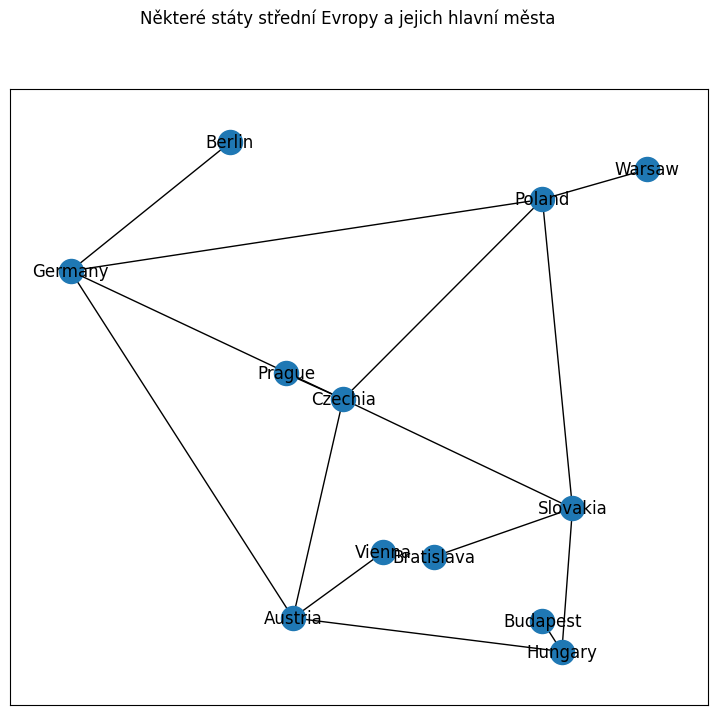

In [19]:
fig, ax = plt.subplots(figsize=(9, 8))
nx.draw_networkx(G, pos=country_pos, with_labels=True)
fig.suptitle("Některé státy střední Evropy a jejich hlavní města")
plt.show()

## 📍Vzdálenosti mezi jednotlivými body

GPS souřadnice bodů jsou užitečné informace, avšak kromě pozice jednotlivých vrcholů nám toho moc neřeknou. Ve 2D světě bychom použili například Euklidovskou vzdálenost, jelikož ale `Země není plochá`, nýbrž kulatá, použijeme [haversinovu formuli](https://math.stackexchange.com/questions/2799399/great-circle-distance-using-haversine-formula), která slouží pro výpočet vzdálenosti dvou bodů na kouli.

> **🗒️ _Poznámka:_**  Někdo by mohl namítat, že země není ani kulatá, máte pravdu je to nepravidelný elipsoid.


In [20]:
def distance(u: str, v: str):
    """Calculates a distance between two GPS points."""

    long1, lat1 = map(math.radians, country_pos[u])
    long2, lat2 = map(math.radians, country_pos[v])

    # Haversine Formula
    delta_long = long2 - long1
    delta_lat = lat2 - lat1

    ans = math.pow(math.sin(delta_lat / 2), 2) + math.pow(
        math.sin(delta_long / 2), 2
    ) * math.cos(lat1) * math.cos(lat2)

    ans = 2 * math.asin(math.sqrt(ans))
    radius_to_km = 6371
    return ans * radius_to_km

In [21]:
distance("Prague", "Bratislava")

291.7539277378406

Což nám postačí, trasa autem podle Google Maps je dlouhá cca 332 km. Zároveň můžeme vzdálenost nastavit jako váhu (`weight`) jednotlivých hran.

In [22]:
for src, dest, edge_attrs in G.edges(data=True):
    edge_attrs["distance"] = f"{int(distance(src, dest))}km"
    edge_attrs["weight"] = distance(src, dest)

In [23]:
# vzdálenost mezi všemi propojenými dvojicemi uzlů
labels = {edge: G.edges[edge]["distance"] for edge in G.edges}
labels

{('Czechia', 'Prague'): '81km',
 ('Czechia', 'Slovakia'): '332km',
 ('Czechia', 'Poland'): '347km',
 ('Czechia', 'Germany'): '385km',
 ('Czechia', 'Austria'): '264km',
 ('Slovakia', 'Bratislava'): '197km',
 ('Slovakia', 'Hungary'): '168km',
 ('Slovakia', 'Poland'): '363km',
 ('Hungary', 'Budapest'): '44km',
 ('Hungary', 'Austria'): '375km',
 ('Poland', 'Warsaw'): '136km',
 ('Poland', 'Germany'): '606km',
 ('Germany', 'Berlin'): '251km',
 ('Germany', 'Austria'): '502km',
 ('Austria', 'Vienna'): '146km'}

Spočtené vzdálenosti můžeme přidat jako **popisky jednotlivých hran**. Pozn.: Stejně jako u jiných grafů, můžete měnit barvu popisků, jejich velikost a pozici. Obdobně jste také schopni ladit zobrazení uzlů (ukážeme si níže).

In [24]:
# data s pozicí popisků hran
pos_attrs = {}
for node, coords in country_pos.items():
    pos_attrs[node] = (coords[0], coords[1] + 0.2)

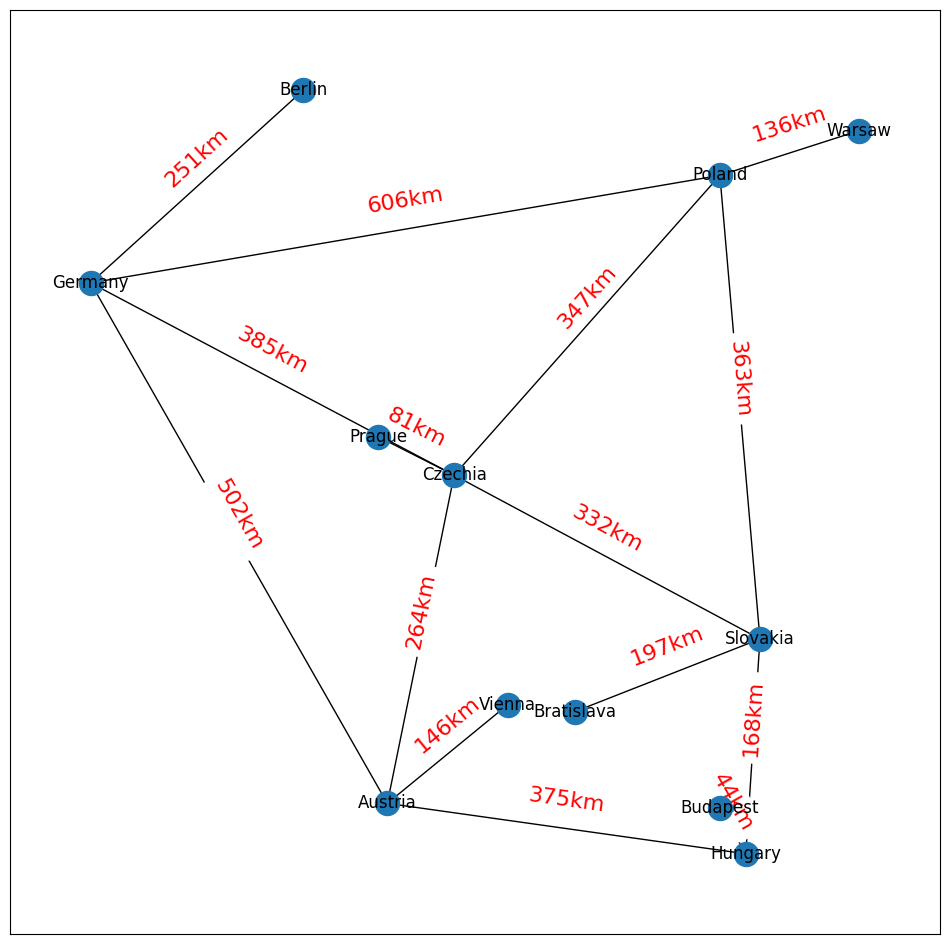

In [25]:
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx(G, pos=country_pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos=pos_attrs, edge_labels=labels, font_color='red', font_size=16)
plt.show()

### 🎨 Obarvení grafu

Grafy lze samozřejmě různě obarvovat. Při vykreslování je třeba každé entitě přiřadit barvu. Je možné použít `hexadecimální barevné kódy` (např. `#eb4034`), stringový identifikátor barvy (`green`), pokud je definovaná v matplotlibu, nebo jejich zkrácené formy (`g`). Obarvit lze hrany, vrcholy, ohraničení vrcholů nebo textové popisky.

In [26]:
country_colormap = [
    "g" if G.nodes[node]["type"] == "country" else "r" for node in G.nodes
]

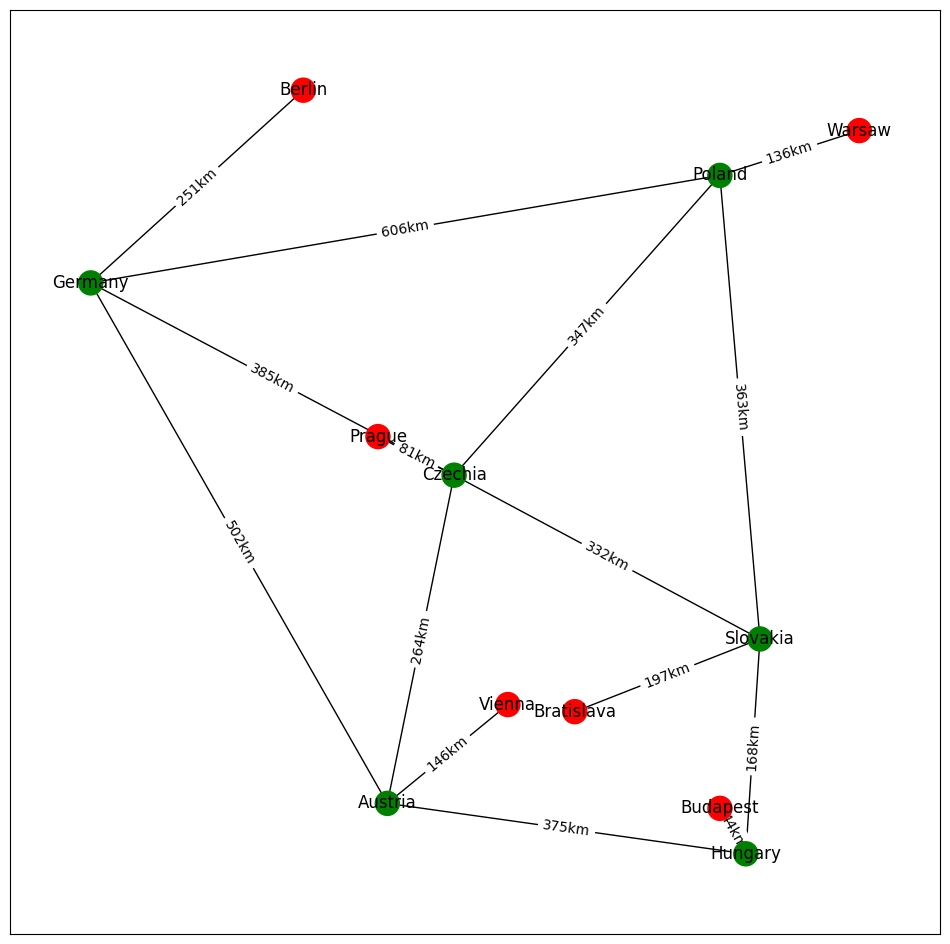

In [27]:
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx(G, with_labels=True, pos=country_pos, node_color=country_colormap)
nx.draw_networkx_edge_labels(G, pos=country_pos, edge_labels=labels)
plt.show()

### 🏁 Pojďme to dotáhnout do úplnosti

In [28]:
# rozdeleni vrcholu na mesta a staty
countries = [
    node for node, node_attr in G.nodes(True) if node_attr["type"] == "country"
]
cities = [node for node, node_attr in G.nodes(True) if node_attr["type"] == "city"]

In [29]:
# rozdeleni hran na mezistatni a vnitrostatni
city_to_country_edges = [
    edge for edge in G.edges if edge[0] in cities or edge[1] in cities
]
inter_state_edges = [
    edge for edge in G.edges if not (edge[0] in cities or edge[1] in cities)
]

In [30]:
# pocty obyvatel ve statisicich
populations = {
    "Berlin": 36,
    "Germany": 832,
    "Prague": 13,
    "Czechia": 107,
    "Warsaw": 17,
    "Poland": 379,
    "Bratislava": 4,
    "Slovakia": 54,
    "Vienna": 18,
    "Austria": 89,
    "Budapest": 17,
    "Hungary": 97,
}
cities_size = [populations[city] for city in cities]
countries_size = [populations[city] for city in countries]

S takto připravenými daty jsme schopni např. měnit velikost uzlu podle počtu obyvatel města/země a pomocí typu čáry rozlišit hranu mezi státy (S-S, `dotted`) nebo mezi státem a městem (C-S, `dashed`). Můžeme upravit i velikost fontu a zobrazit si legendu.

<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:32: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:32: SyntaxWarning: invalid escape sequence '\l'
/var/folders/7p/xc_5p2qx0kn5zwk_h1dkhbv80000gn/T/ipykernel_44734/410701009.py:25: SyntaxWarning: invalid escape sequence '\l'
  label="$C \leftrightarrow S$",
/var/folders/7p/xc_5p2qx0kn5zwk_h1dkhbv80000gn/T/ipykernel_44734/410701009.py:32: SyntaxWarning: invalid escape sequence '\l'
  label="$S \leftrightarrow S$",


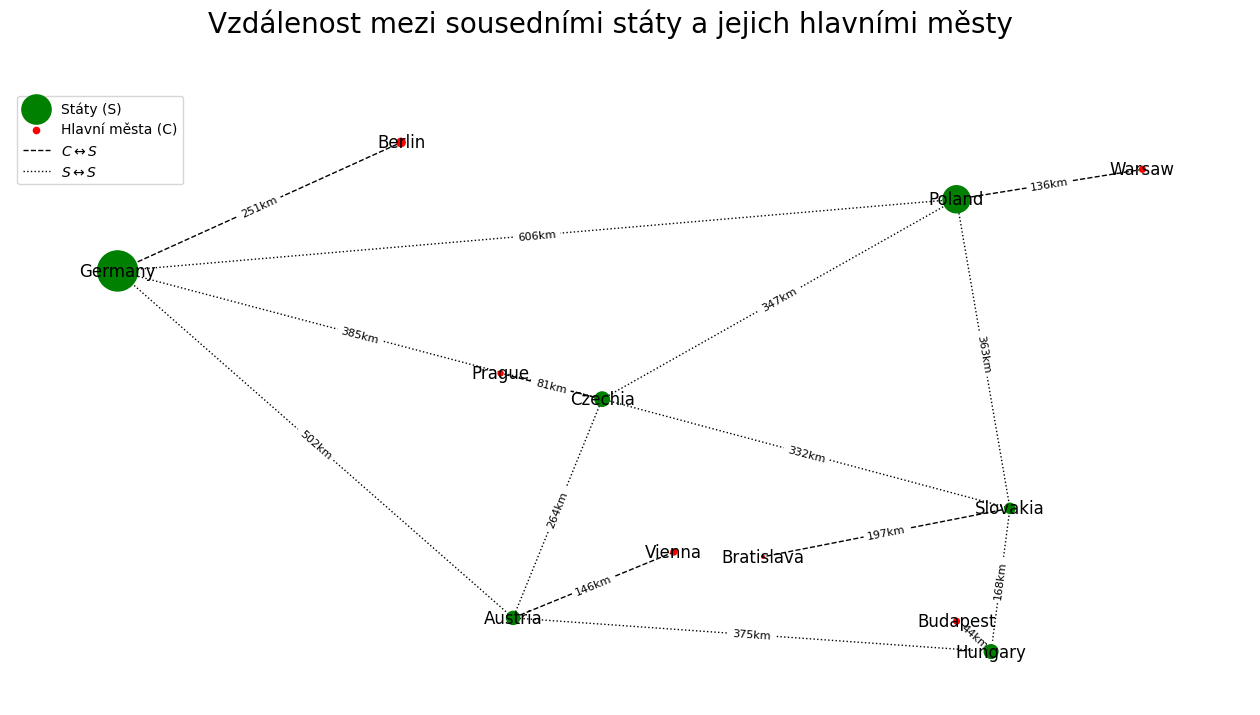

In [31]:
fig, ax = plt.subplots(figsize=(16, 8))

nx.draw_networkx_nodes(
    G,
    country_pos,
    nodelist=countries,
    node_color="green",
    label="Státy (S)",
    node_size=countries_size,
)
nx.draw_networkx_nodes(
    G,
    country_pos,
    nodelist=cities,
    node_color="red",
    label="Hlavní města (C)",
    node_size=cities_size,
)

nx.draw_networkx_edges(
    G,
    country_pos,
    style="dashed",
    edgelist=city_to_country_edges,
    label="$C \leftrightarrow S$",
)
nx.draw_networkx_edges(
    G,
    country_pos,
    style="dotted",
    edgelist=inter_state_edges,
    label="$S \leftrightarrow S$",
)

nx.draw_networkx_labels(G, country_pos)

nx.draw_networkx_edge_labels(G, pos=country_pos, edge_labels=labels, font_size=8)
plt.legend()
fig.suptitle("Vzdálenost mezi sousedními státy a jejich hlavními městy", size=20)
plt.axis("off")

plt.show()

## ☝️ Další důležité funkcionality NetworkX

S `G.nodes` jsme se již potkali, avšak budeme-li chtít přistupovat k atributům vrcholů, potřebujeme přidat parametr `data=True`. 

In [32]:
G.nodes(data=True)

NodeDataView({'Czechia': {'type': 'country'}, 'Prague': {'type': 'city', 'population': 1309000}, 'Slovakia': {'type': 'country'}, 'Hungary': {'type': 'country'}, 'Poland': {'type': 'country'}, 'Germany': {'type': 'country'}, 'Austria': {'type': 'country'}, 'Bratislava': {'type': 'city'}, 'Budapest': {'type': 'city'}, 'Warsaw': {'type': 'city'}, 'Berlin': {'type': 'city'}, 'Vienna': {'type': 'city'}})

Obdobně pak pracujeme s hranami.

In [33]:
G.edges

EdgeView([('Czechia', 'Prague'), ('Czechia', 'Slovakia'), ('Czechia', 'Poland'), ('Czechia', 'Germany'), ('Czechia', 'Austria'), ('Slovakia', 'Bratislava'), ('Slovakia', 'Hungary'), ('Slovakia', 'Poland'), ('Hungary', 'Budapest'), ('Hungary', 'Austria'), ('Poland', 'Warsaw'), ('Poland', 'Germany'), ('Germany', 'Berlin'), ('Germany', 'Austria'), ('Austria', 'Vienna')])

In [34]:
G.edges(data=True)

EdgeDataView([('Czechia', 'Prague', {'type': 'capital', 'distance': '81km', 'weight': 81.06729602879068}), ('Czechia', 'Slovakia', {'relation': 'neighbour', 'distance': '332km', 'weight': 332.2417956173501}), ('Czechia', 'Poland', {'relation': 'neighbour', 'distance': '347km', 'weight': 347.82218390435736}), ('Czechia', 'Germany', {'relation': 'neighbour', 'distance': '385km', 'weight': 385.45747331946063}), ('Czechia', 'Austria', {'relation': 'neighbour', 'distance': '264km', 'weight': 264.7059693698347}), ('Slovakia', 'Bratislava', {'type': 'capital', 'distance': '197km', 'weight': 197.2033342697801}), ('Slovakia', 'Hungary', {'relation': 'neighbour', 'distance': '168km', 'weight': 168.15236185678165}), ('Slovakia', 'Poland', {'relation': 'neighbour', 'distance': '363km', 'weight': 363.56161662509004}), ('Hungary', 'Budapest', {'type': 'capital', 'distance': '44km', 'weight': 44.52372036012399}), ('Hungary', 'Austria', {'relation': 'neighbour', 'distance': '375km', 'weight': 375.2364

Chceme-li pracovat s nějakou specifickou hranou nebo vrcholem, stačí k němu přistoupit pomocí jeho identifikátoru.

### 🔍 Přístup k atributům

In [35]:
G.nodes["Prague"]

{'type': 'city', 'population': 1309000}

In [36]:
G.nodes["Prague"]["type"]

'city'

In [37]:
G.edges[("Prague", "Czechia")]

{'type': 'capital', 'distance': '81km', 'weight': 81.06729602879068}

### ☝️ Stupně vrcholů

In [38]:
G.degree

DegreeView({'Czechia': 5, 'Prague': 1, 'Slovakia': 4, 'Hungary': 3, 'Poland': 4, 'Germany': 4, 'Austria': 4, 'Bratislava': 1, 'Budapest': 1, 'Warsaw': 1, 'Berlin': 1, 'Vienna': 1})

In [39]:
G.degree("Czechia")

5

U orientovaných grafů je dobré mít na mysli, že: `G.degree[node] = G.in_degree[node] + G.out_degree[node]` 

### 🏘 Sousední vrcholy

In [40]:
for x in nx.all_neighbors(G, "Czechia"):
    print(x)

Prague
Slovakia
Poland
Germany
Austria


### 🕸 Hustota grafu

Hustota grafu vypovídá o jeho provázanosti. Konkrétně se jedná o poměr přítomných hran ku všem možným hranám. Její hodnota se pohybuje od 0 do 1.

In [41]:
nx.density(G)

0.22727272727272727

Tedy vidíme, že hustota grafu je nízká a státy a města tak nejsou mezi sebou příliš propojená.

### ☝️ Test silné souvislosti

Tzn. zda se jedná o souvislý graf (pro každou dvojici uzlů existuje cesta), tj. takový graf, který má pouze jednu komponentu souvislosti.

In [42]:
nx.is_connected(G)

True

### 👩‍👧 Podgraf 

Občas se stane, že potřebujeme pracovat jenom s podgrafem. K tomu využijeme metodu `subgraph(nodes)`, která na základě seznamu vrcholů vytvoří podgraf. Metoda vrací pouze `immutable` view na původní graf. 

In [43]:
# pouze státy
C = G.subgraph(countries)

<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
/var/folders/7p/xc_5p2qx0kn5zwk_h1dkhbv80000gn/T/ipykernel_44734/2595458313.py:17: SyntaxWarning: invalid escape sequence '\l'
  label="$S_u \leftrightarrow S_v$",


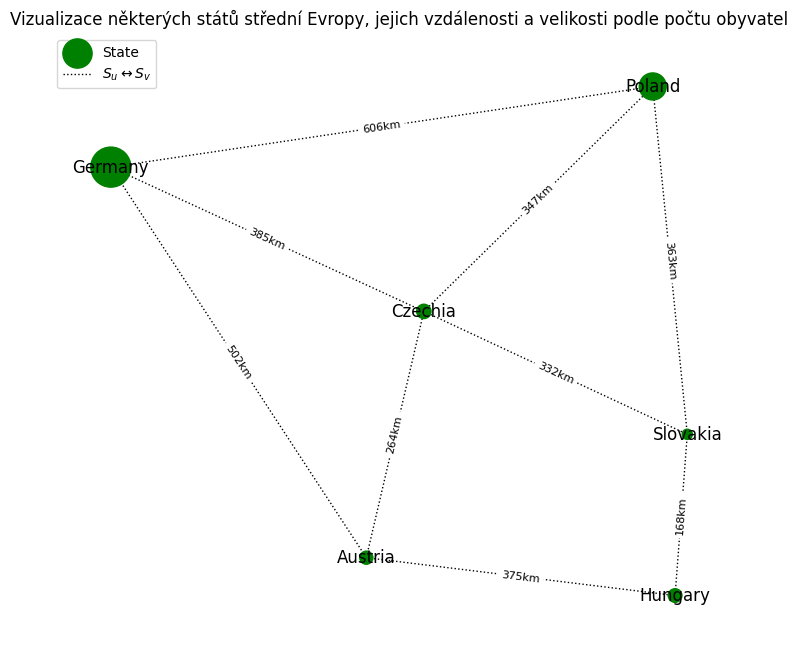

In [44]:
fig, ax = plt.subplots(figsize=(9, 8))

nx.draw_networkx_nodes(
    C,
    country_pos,
    nodelist=countries,
    node_color="green",
    label="State",
    node_size=countries_size,
)

nx.draw_networkx_edges(
    C,
    country_pos,
    style="dotted",
    edgelist=inter_state_edges,
    label="$S_u \leftrightarrow S_v$",
)

nx.draw_networkx_labels(C, country_pos)
# nx.draw(G, with_labels=True, pos=country_pos, node_color=country_colormap);
nx.draw_networkx_edge_labels(
    C,
    pos=country_pos,
    edge_labels={
        (src, dest): v
        for (src, dest), v in labels.items()
        if src in countries and dest in countries
    },
    font_size=8,
)
plt.legend()
ax.set_title(
    "Vizualizace některých států střední Evropy, jejich vzdálenosti a velikosti podle počtu obyvatel"
)
plt.axis("off")
plt.show()

## 🚀 Pokročilejší funkcionality

### 🪚 Hranové řezy

[Hranový řez](https://en.wikipedia.org/wiki/Bridge_%28graph_theory%29#Bridge-Finding_with_Chain_Decompositions) představuje takovou minimální množinu hran, po jejímž odstranění se graf stane nesouvislým. Tzn. že po odstranění takové hrany dojde ke zvýšení počtu komponent grafu. Odstraněná hrana zároveň není součástí žádného cyklu.

In [45]:
list(nx.bridges(G))

[('Czechia', 'Prague'),
 ('Slovakia', 'Bratislava'),
 ('Hungary', 'Budapest'),
 ('Poland', 'Warsaw'),
 ('Germany', 'Berlin'),
 ('Austria', 'Vienna')]

Abychom vytvořili nesouvislý graf, stačí nám odstranit právě jednu hranu, která spojuje stát a jeho hlavní město.

### ☝️ Kliky v grafu

Klika grafu je takovým podgrafem, který je úplným grafem, tzn. jehož všechny vrcholy jsou spojeny hranou se všemi zbylými. 

Pokud používáte novější verze NetworkX (např. 3.4.2), můžete nalézt kliky v grafu pomocí funkce [find_cliques()](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.clique.find_cliques.html).

In [46]:
cliques = list(filter(lambda x: len(x) > 2, nx.enumerate_all_cliques(G)))
cliques

[['Czechia', 'Slovakia', 'Poland'],
 ['Czechia', 'Poland', 'Germany'],
 ['Czechia', 'Germany', 'Austria']]

Nebo kliky, které obsahují konkrétní uzel.

In [47]:
nx.algorithms.clique.cliques_containing_node(G, nodes=["Czechia"])

AttributeError: module 'networkx.algorithms.clique' has no attribute 'cliques_containing_node'

Kliky můžete různými způsoby v grafu vizualizovat:

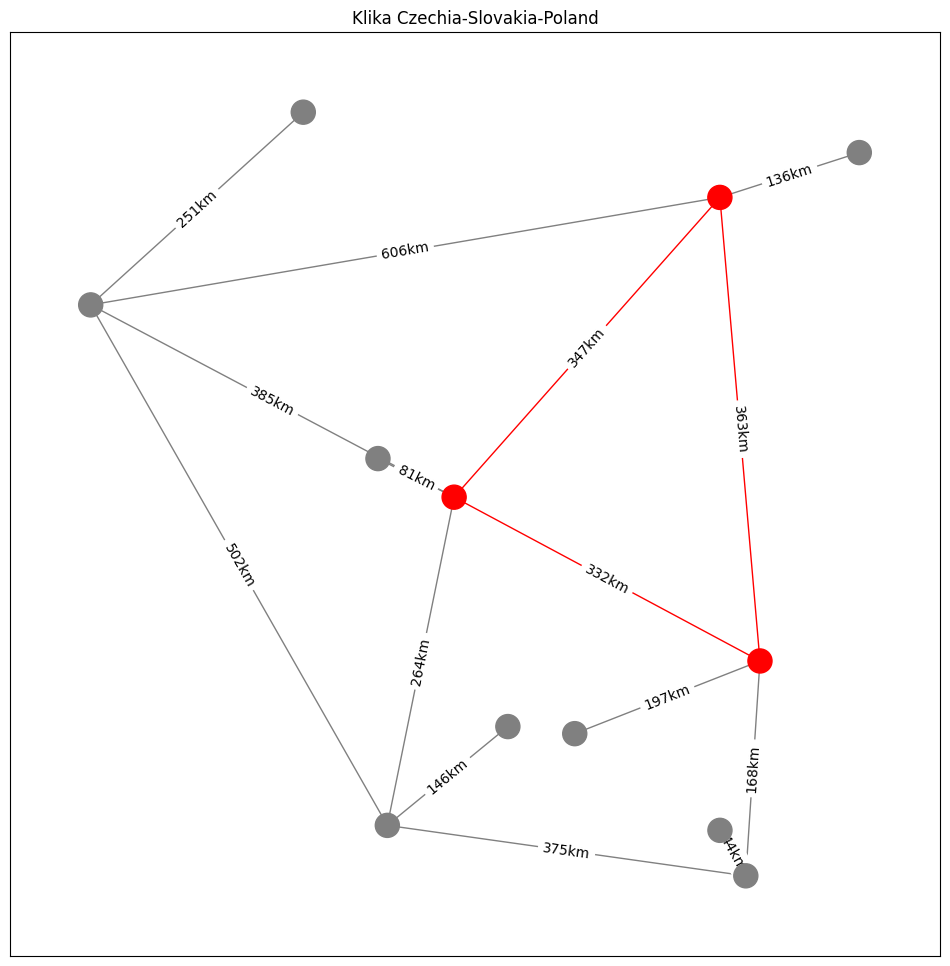

In [ ]:
clique_idx = 0
assert clique_idx < len(cliques)

fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_nodes(
    G,
    label=True,
    pos=country_pos,
    node_color=["red" if node in cliques[clique_idx] else "grey" for node in G.nodes],
)
nx.draw_networkx_edges(
    G,
    label=True,
    pos=country_pos,
    edge_color=[
        "red" if edge in G.subgraph(cliques[clique_idx]).edges else "grey"
        for edge in G.edges
    ],
)
nx.draw_networkx_edge_labels(G, pos=country_pos, edge_labels=labels)
plt.title(f"Klika {'-'.join(cliques[clique_idx])}")
plt.show()

### ☝️ Nejkratší cesty 

Seznam nejkratších cest mezi `source` a `target` uzlem získáme pomocí metody [all_shortest_paths(G, source, target, weight=None, method='dijkstra')](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.all_shortest_paths.html).

In [ ]:
list(nx.all_shortest_paths(G, "Prague", "Budapest"))

[['Prague', 'Czechia', 'Slovakia', 'Hungary', 'Budapest'],
 ['Prague', 'Czechia', 'Austria', 'Hungary', 'Budapest']]

Pokud máme vážený graf (hrana má atribut `weight` - číslo ), můžeme k hledání nejkratší cesty použít algoritmy k tomu určené. Například A* [`astar`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.astar.astar_path.html).

In [ ]:
list(nx.astar_path(G, "Berlin", "Budapest"))

['Berlin', 'Germany', 'Austria', 'Hungary', 'Budapest']

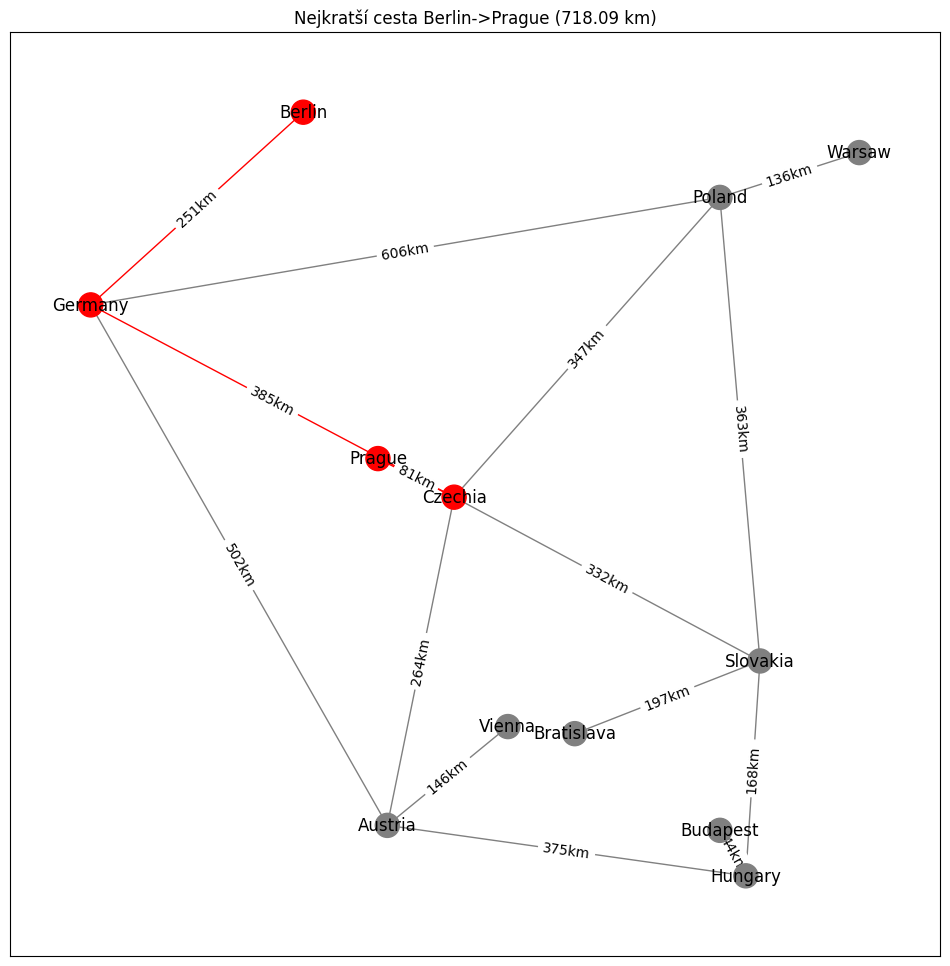

In [ ]:
src, dest = "Berlin", "Prague"
path = list(nx.astar_path(G, src, dest))

edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]

fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_nodes(
    G,
    label=True,
    pos=country_pos,
    node_color=["red" if node in path else "grey" for node in G.nodes],
)
nx.draw_networkx_edges(
    G,
    label=True,
    pos=country_pos,
    edge_color=[
        "red" if edge in edges or edge[::-1] in edges else "grey" for edge in G.edges
    ],
)
nx.draw_networkx_edge_labels(G, pos=country_pos, edge_labels=labels)
nx.draw_networkx_labels(G, pos=country_pos)
plt.title(
    f"Nejkratší cesta {src}->{dest} ({sum([G.edges[edge]['weight'] for edge in edges]):6.2f} km)"
)
plt.show()

A samozřejmě vše ostatní co najdete v dokumentaci...

## 🔀 Náhodně generované grafy

Kromě vytváření vlastních grafů a používání grafových datasetů je v `NetworkX` možné generovat umělé grafy. Například pomocí [`nx.gaussian_random_partition_graph(n, s, v, p_in, p_out,)`](https://networkx.org/documentation/stable/reference/generated/networkx.generators.community.gaussian_random_partition_graph.html), kde: 
- `n` je počet vrcholů
- `s` je průměrná velikost clusterů
- `v` je rozptyl velikosti clusterů
- `p_in` je pravděpodobnost že mezi vrcholy uvnitř clusteru vznikne hrana
- `p_out` je pravděpodobnost že mezi vrcholy z jiných clusterů vznikne hrana

🛠 Na ukázku si vytvoříme graf, který bude mít mezi `3` až `6` souvislými komponentami.

Pro vytváření grafů existují i další způsoby, vizte [`generátory grafů`](https://networkx.org/documentation/stable/reference/generators.html).

In [ ]:
gaussian = nx.gaussian_random_partition_graph(250, 62, 1.3, 0.5, 0.0)
while not len(list(nx.components.connected_components(gaussian))) in range(3, 6):
    gaussian = nx.gaussian_random_partition_graph(250, 62, 1.3, 0.5, 0.0)
    
nx.number_connected_components(gaussian)

5

In [ ]:
# odebereme izolované vrcholy, tak můžeme zmenšit počet komponent
for x in list(nx.components.connected_components(gaussian)):
    if len(x) == 1:
        gaussian.remove_nodes_from(x)

nx.number_connected_components(gaussian)

5

Vidíte, že nedošlo k odstranění žádných komponent. Před tímto krokem by se hodilo provést analýzu, kolik uzlů se nachází v každé komponentě a dle toho filtrovat. To si můžete zkusit za ⭐️**domácí úkol**⭐️.

Pro zmenšení velikosti grafu existuje několik přístupů, vždy však záleží na dané úloze. Provedenou úpravu musíte mít po zbytek analýzy na paměti, abyste nevyvodili chybné/zkreslené závěry.

In [ ]:
# má pouze jednu komponentu souvislosti?
nx.is_connected(gaussian)

False

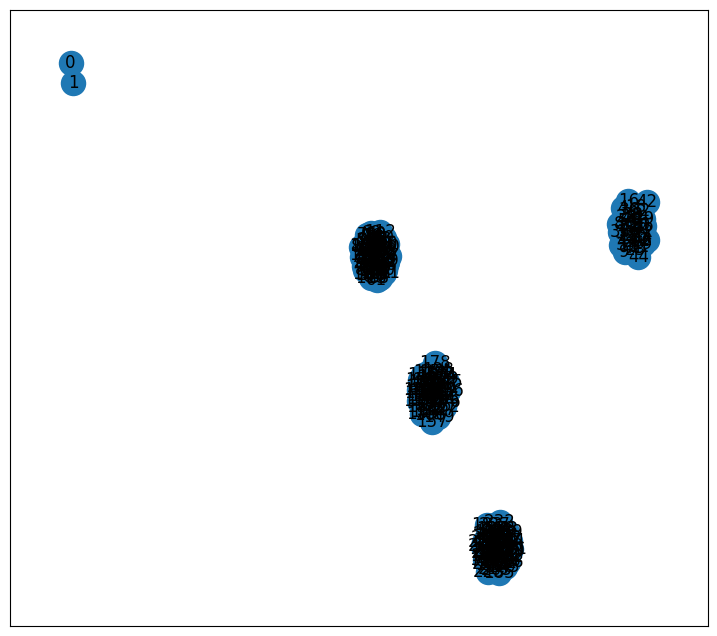

In [ ]:
fig, ax = plt.subplots(figsize=(9, 8))
nx.draw_networkx(gaussian, pos=nx.spring_layout(gaussian))
plt.show()

In [ ]:
first_component = gaussian.subgraph(
    list(nx.components.connected_components(gaussian))[0]
)

In [ ]:
fig = plt.figure(figsize=(5, 5))
nx.draw_networkx(first_component, with_labels=True)

In [ ]:
print(first_component)

Ve vygenerovaném grafu můžeme provést **analýzu stupňů vrcholu** 🕵🏻‍♂️. My si ji vyzkoušíme pro všechny komponenty vygenerovaného grafu, ale mohlo by být zajímavé analyzovat každou komponentu zvlášť ☝️.

In [ ]:
degrees = [d for n, d in gaussian.degree()]
degreeCount = collections.Counter(degrees)
deg, cnt = zip(*degreeCount.items())

In [ ]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(16, 10))
ax.hist(degrees, bins=max(degrees) - min(degrees))

ax.set_title("Histogram stupňů vrcholů")
ax.set_ylabel("Počet")
ax.set_xlabel("Stupeň")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

ax2.boxplot([d for n, d in gaussian.degree()], notch=True, vert=False)
ax2.set_title("Boxplot stupňů vrcholů")
ax2.set_xlabel("Stupeň")
plt.suptitle("Analýza stupňů vrcholů náhodně vygenerovaného grafu", size=15)
plt.show()

O stupních vrcholů lze také získat základní statistiky:

In [ ]:
print(f"Min:\t{np.min(degrees)}")
print(f"Max:\t{np.max(degrees)}")
print(f"Mean:\t{np.mean(degrees)}")
print(f"Std:\t{np.std(degrees)}")
print(f"Medián:\t{np.median(degrees)}")

## ☝️ Centrality v grafu

In [ ]:
# si neukážeme, protože je budete řešit v rámci domácího úkolu

## ☝️ Serializace

NetworkX umí serializovat data například ve formáru `json`, nebo `txt`.  

In [ ]:
nx.write_adjlist(G, "country_graph.txt")

In [ ]:
%%bash
cat country_graph.txt | head -n 20

In [ ]:
loaded_country = nx.read_adjlist("country_graph.txt", create_using=nx.DiGraph)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 8))
nx.draw_networkx(loaded_country, pos=country_pos, with_labels=True)
plt.show()

# 🎉 To je ze seznámení se s NetworkX vše! 🎉